In [ ]:
import os
import imageio
import numpy as np
from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision
import torch.nn as nn

import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install py7zr
!unzip -qq "/content/drive/MyDrive/애니메이션키포인트PJ/FacialLandmarkManga-master.zip"
!unzip -qq "/content/drive/MyDrive/애니메이션키포인트PJ/Manga109.zip"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- landmark파일에 적혀있는 page랑 face번호가 xml파일에 있는 어떤 정보와도 일치하지 않기 때문에 직접 찾아야함
- 단, 랜드마크 위치좌표만 수정하면 사이즈를 조정하지 않아도 cropped image에 딱 맞게 바뀜 
- 그러므로 cropped image를 다 뽑고 그 위에 landmark를 씌우고 맞는걸 직접 골라야함. 근데 개많고 오래걸릴듯.

In [ ]:
import py7zr

with py7zr.SevenZipFile('/content/FacialLandmarkManga-master/landmarksUser.7z', mode='r') as z:
    z.extractall()

# 이미지 랜드마크 매칭 프로그램 
- 갖가지 트릭을 써서 랜드마크에 해당하는 이미지를 최대한 추려놓음 
- 아래 코드를 실행시키고 하라는대로 하면 됨 
- 2번을 누르면 이미지 다시 선택 
- 1번을 누르면 이미지의 랜드마크 위치만 재조정 
- 0번을 누르면 .npz로 이미지와 랜드마크를 저장함 (아직 제대로 불러와지는지 확인안함)
- -1번을 누르면 이번 랜드마크 넘어가고 다음 랜드마크 로딩함 (도저히 모르겠다 싶으면 쓰면 됨)
- 한 사람당 100개씩만 도와줘도 데이터셋 300개 만들 수 있음 (나는 300개 더 추가하면 총 데이터 500개 됨)
- **필독 : 나눠준 랜드마크를 100개를 다 올려서하지말고 한 20개정도로 끊어서 로딩하는 걸 반복해야함** 

이유 : 매칭작업하다가 커널터지는 등 예기치 못한 상태로 끊겨도 지금까지 한 걸 저장하게끔 해놨긴했는데 그래도 무슨 이상사태가 발생할지모름

In [ ]:
from numpy.core.fromnumeric import nonzero
import json


os.makedirs('./drive/MyDrive/Temp/img_landmark_dataset')
save_path = './drive/MyDrive/Temp/img_landmark_dataset'
root_file_list = os.listdir()
landmark_file_list = [i for i in root_file_list if 'user' in i]
landmark_file_list = sorted(landmark_file_list)
landmark_title_list = []
for i in landmark_file_list:
  temp = i[6:].split('_')
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  temp = '_'.join(temp)
  landmark_title_list.append(temp)

for landmark_idx, landmark_file in enumerate(landmark_file_list):
  print(f'랜드마크 번호 : {landmark_idx}')
  temp = landmark_file[6:].split('_')
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  title = '_'.join(temp)


  cropped_image_list = []
  with open(landmark_file,'r') as f:
    json_data = json.load(f)
  x = []
  y = []
  for part in list(json_data['Face'].keys()):
    try:
      [x.append(i) for i in np.array(json_data['Face'][part]['Landmarks'])[:,0]]
      [y.append(i) for i in np.array(json_data['Face'][part]['Landmarks'])[:,1]]
    except:
      continue
  
  title_image_path = f'/content/Manga109_released_2021_12_30/images/{title}'
  title_xml_path = f'/content/Manga109_released_2021_12_30/annotations.v2018.05.31/{title}.xml'
  tree = ET.parse(title_xml_path)
  root = tree.getroot()
  page_list = sorted(os.listdir(title_image_path))
  for page in page_list:
    image = cv2.imread(os.path.join(title_image_path, page))
    page_index = int(page.split('.')[0])
    for face_idx in range(len(root[1][page_index].findall('face'))):
      xmin = int(root[1][page_index].findall('face')[face_idx].attrib['xmin'])
      ymin = int(root[1][page_index].findall('face')[face_idx].attrib['ymin'])
      xmax = int(root[1][page_index].findall('face')[face_idx].attrib['xmax'])
      ymax = int(root[1][page_index].findall('face')[face_idx].attrib['ymax'])
      cropped_image = image[ymin:ymax,xmin:xmax]
      cropped_image_list.append(cropped_image)
  
  selected_cropped_image_list = []
  for image in cropped_image_list:
    x_ = [i-(max(x)-image.shape[1]) for i in x]
    y_ = [i-(max(y)-image.shape[0]) for i in y]
    if np.abs(max(x_)-image.shape[1]) < 20 and np.abs(max(y_)-image.shape[0]) < 20:
      if min(x_) >= 0 or min(y_) >= 0:
        if image.shape[1]/3 > min(x_) and image.shape[0]/3 > min(y_):
          selected_cropped_image_list.append(image)
  rows = 10
  cols = 10

  for show_page in range(len(selected_cropped_image_list)//(rows*cols)+1):
    print(f'page : {show_page}/{len(selected_cropped_image_list)//(rows*cols)}')
    f, ax = plt.subplots(rows,cols, figsize=(30,30))
  
    for image_idx, image_num in tqdm(enumerate(range(show_page*rows*cols,show_page*rows*cols+rows*cols))):
      try:
        x_ = [i-(max(x)-selected_cropped_image_list[image_num].shape[1]) for i in x]
        y_ = [i-(max(y)-selected_cropped_image_list[image_num].shape[0]) for i in y]
        ax[image_idx//rows][image_idx%cols].imshow(selected_cropped_image_list[image_num])
        ax[image_idx//rows][image_idx%cols].set_title(f'num:{image_num}')
        ax[image_idx//rows][image_idx%cols].scatter(x_,y_,s=5,color='red')
        ax[image_idx//rows][image_idx%cols].get_xaxis().set_visible(False)
        ax[image_idx//rows][image_idx%cols].get_yaxis().set_visible(False)
        
      except IndexError as e:
        break
    plt.show()
  
  while True:
    flag = None
    save_img_num = int(input('image num : '))
    x_ = [i-(max(x)-selected_cropped_image_list[save_img_num].shape[1]) for i in x]
    y_ = [i-(max(y)-selected_cropped_image_list[save_img_num].shape[0]) for i in y]
    plt.imshow(selected_cropped_image_list[save_img_num])
    plt.scatter(x_,y_,s=5,c='red')
    plt.show()
    while True:
      x_move = int(input('x 이동량:'))
      y_move = int(input('y 이동량:'))
      x__ = [i+x_move for i in x_]
      y__ = [i+y_move for i in y_]
      plt.imshow(selected_cropped_image_list[save_img_num])
      plt.scatter(x__,y__,s=5,c='red')
      plt.show()
      next = int(input('더 수정하고 싶으면 : 1 이미지를 다시 선택하려면 2 끝내고 싶으면 0을 이건못찾겠다 싶으면 -1을 입력하세요.\n'))
      
      if next==2:
        break
      elif next==-1:
        flag=True
        break
      elif next==0:
        np.save(f'{save_path}/img_{landmark_file}',np.array(selected_cropped_image_list[save_img_num]))
        np.save(f'{save_path}/landmark_{landmark_file}',np.stack([np.array(x__),np.array(y__)], axis=1))
        flag=True
        break
    if flag==True:
      break

랜드마크 번호 : 0
page : 0/2


0it [00:00, ?it/s]

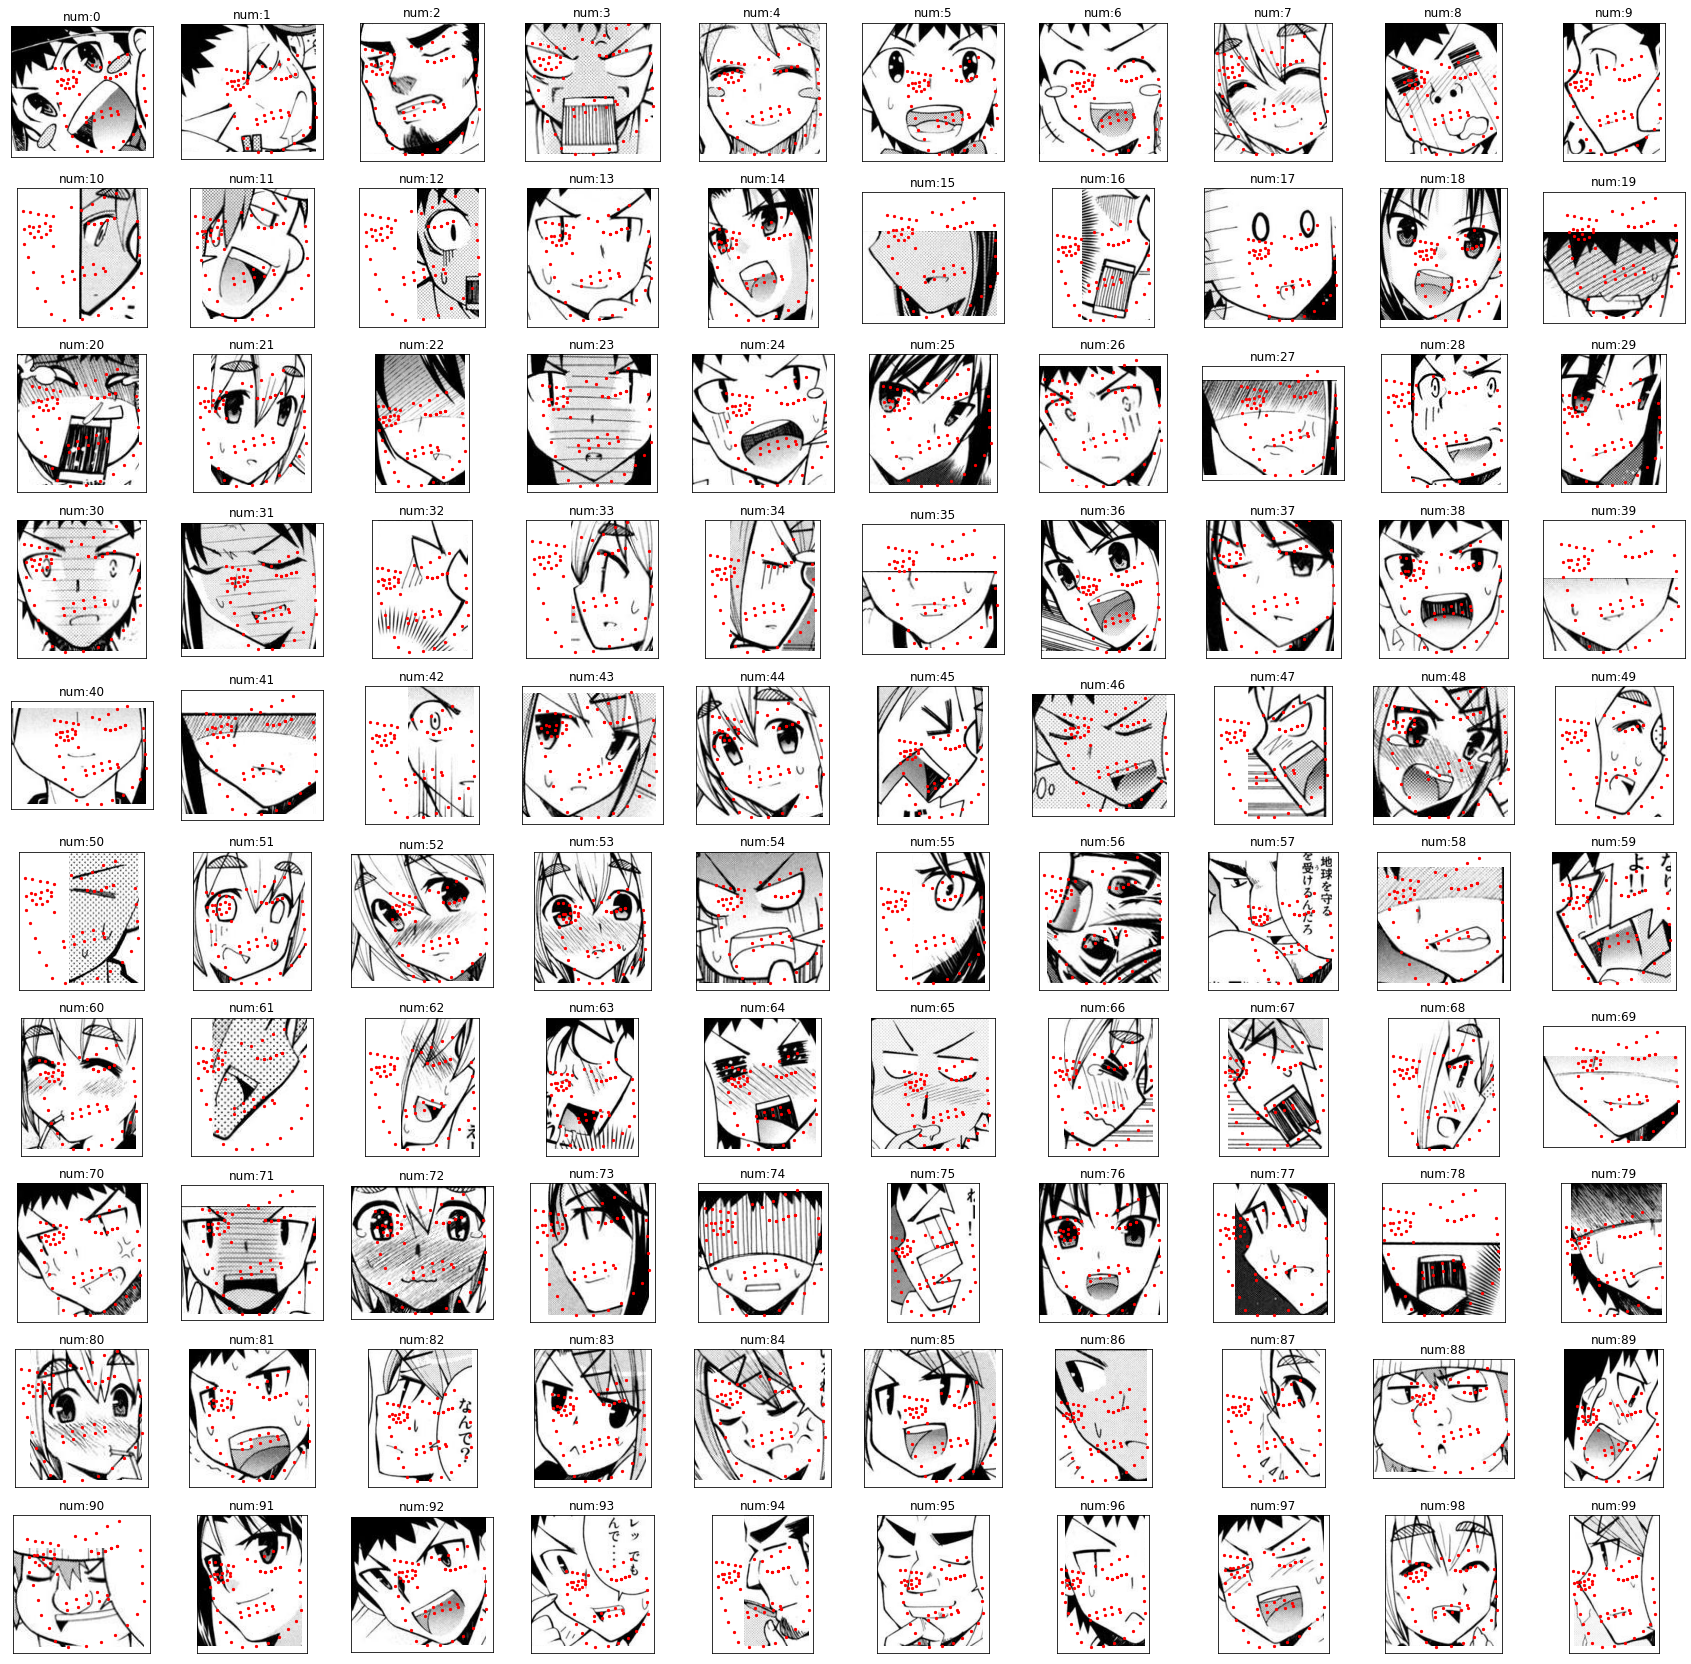

page : 1/2


0it [00:00, ?it/s]

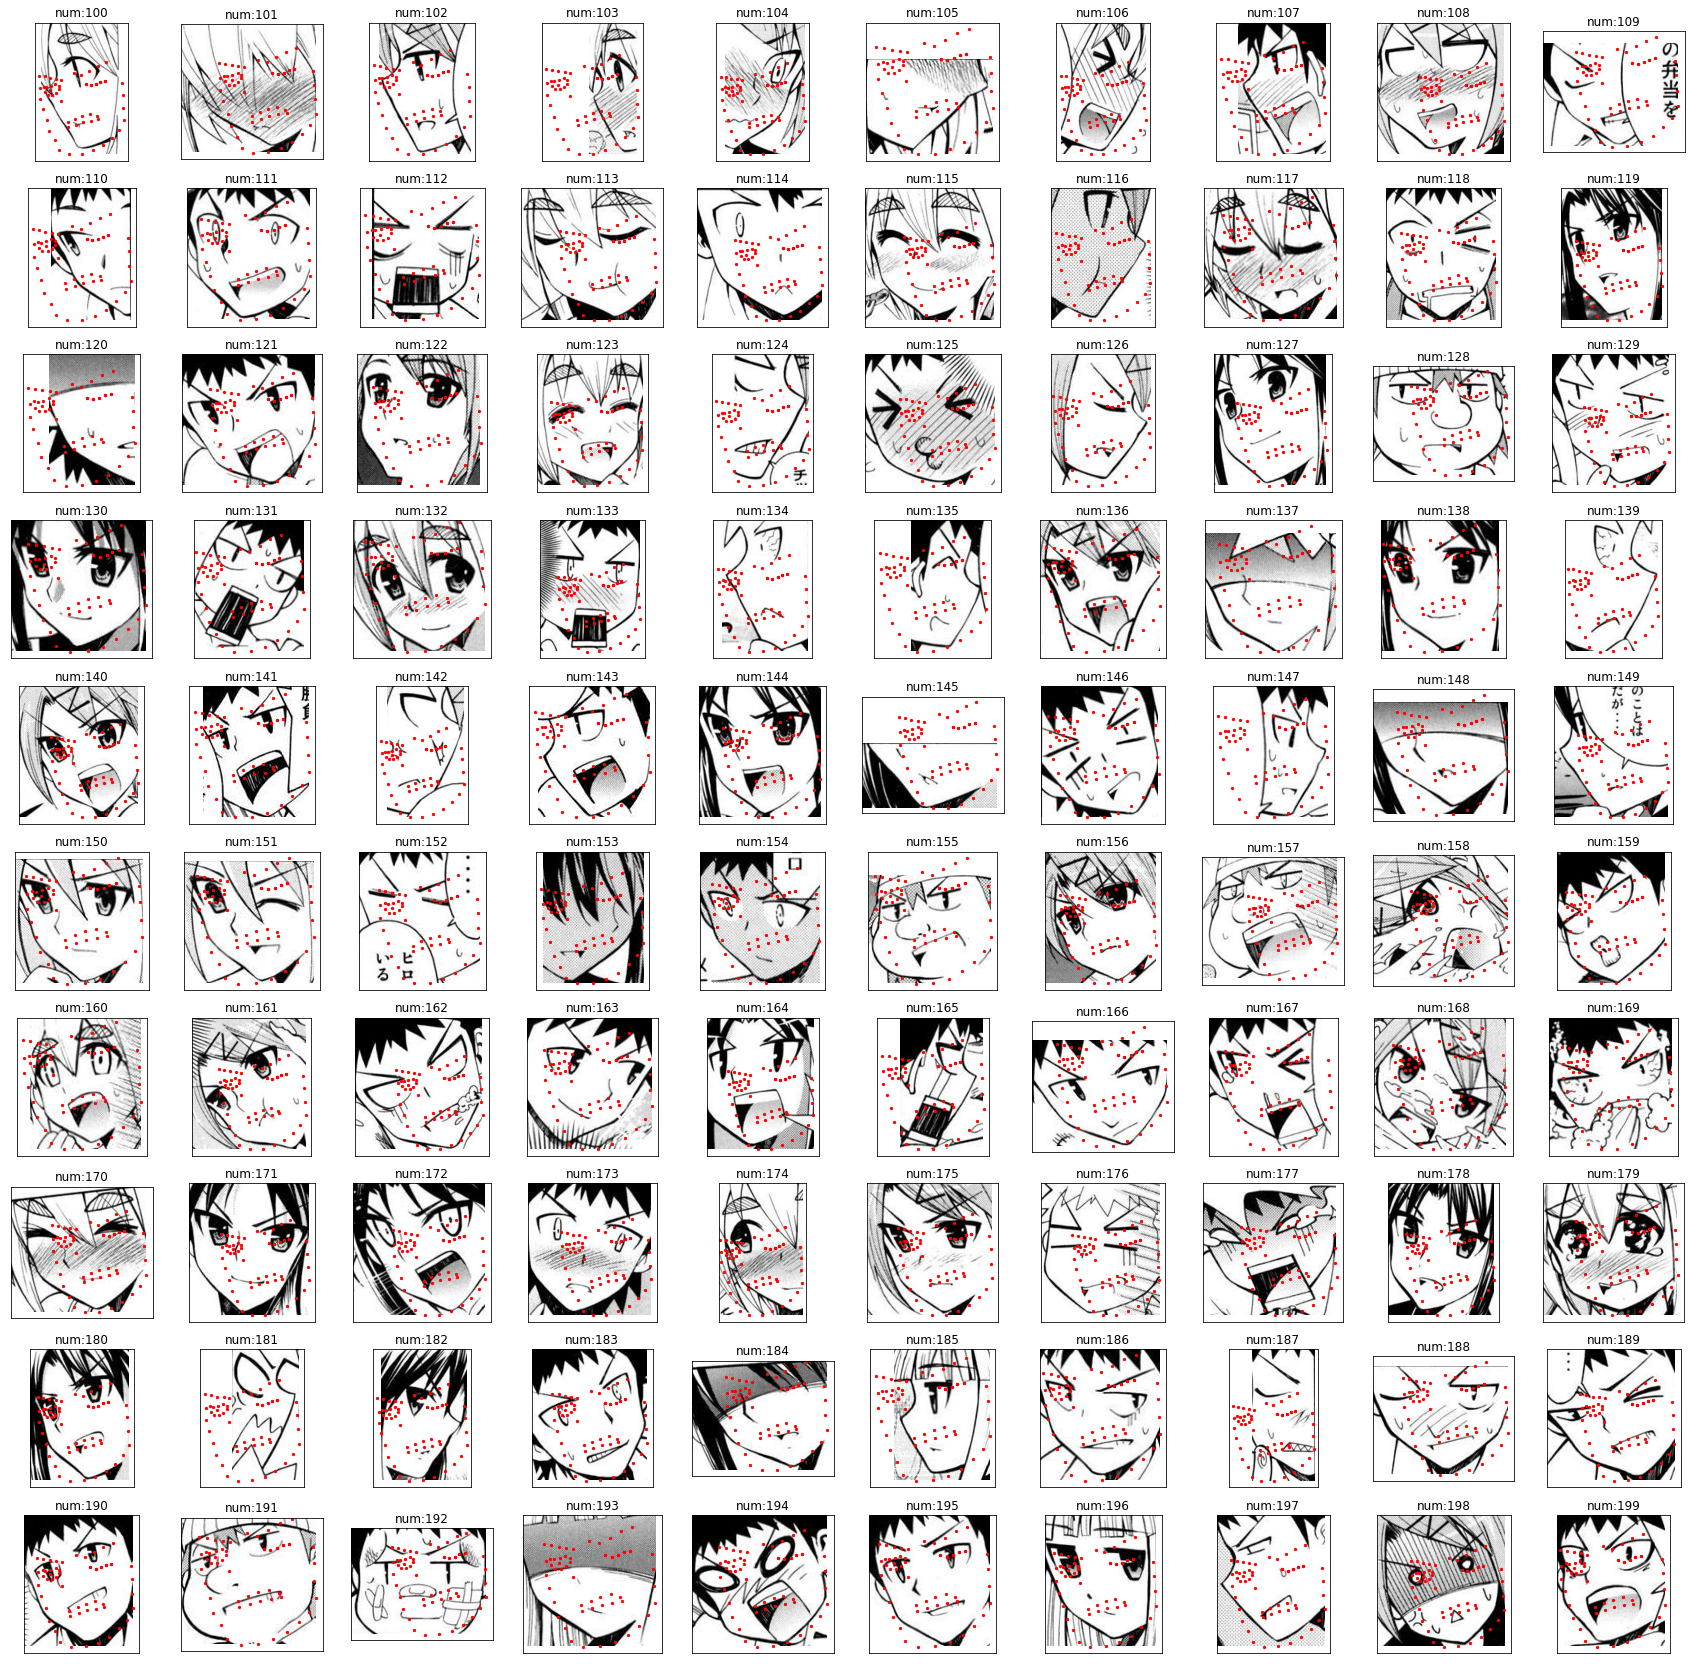

page : 2/2


0it [00:00, ?it/s]

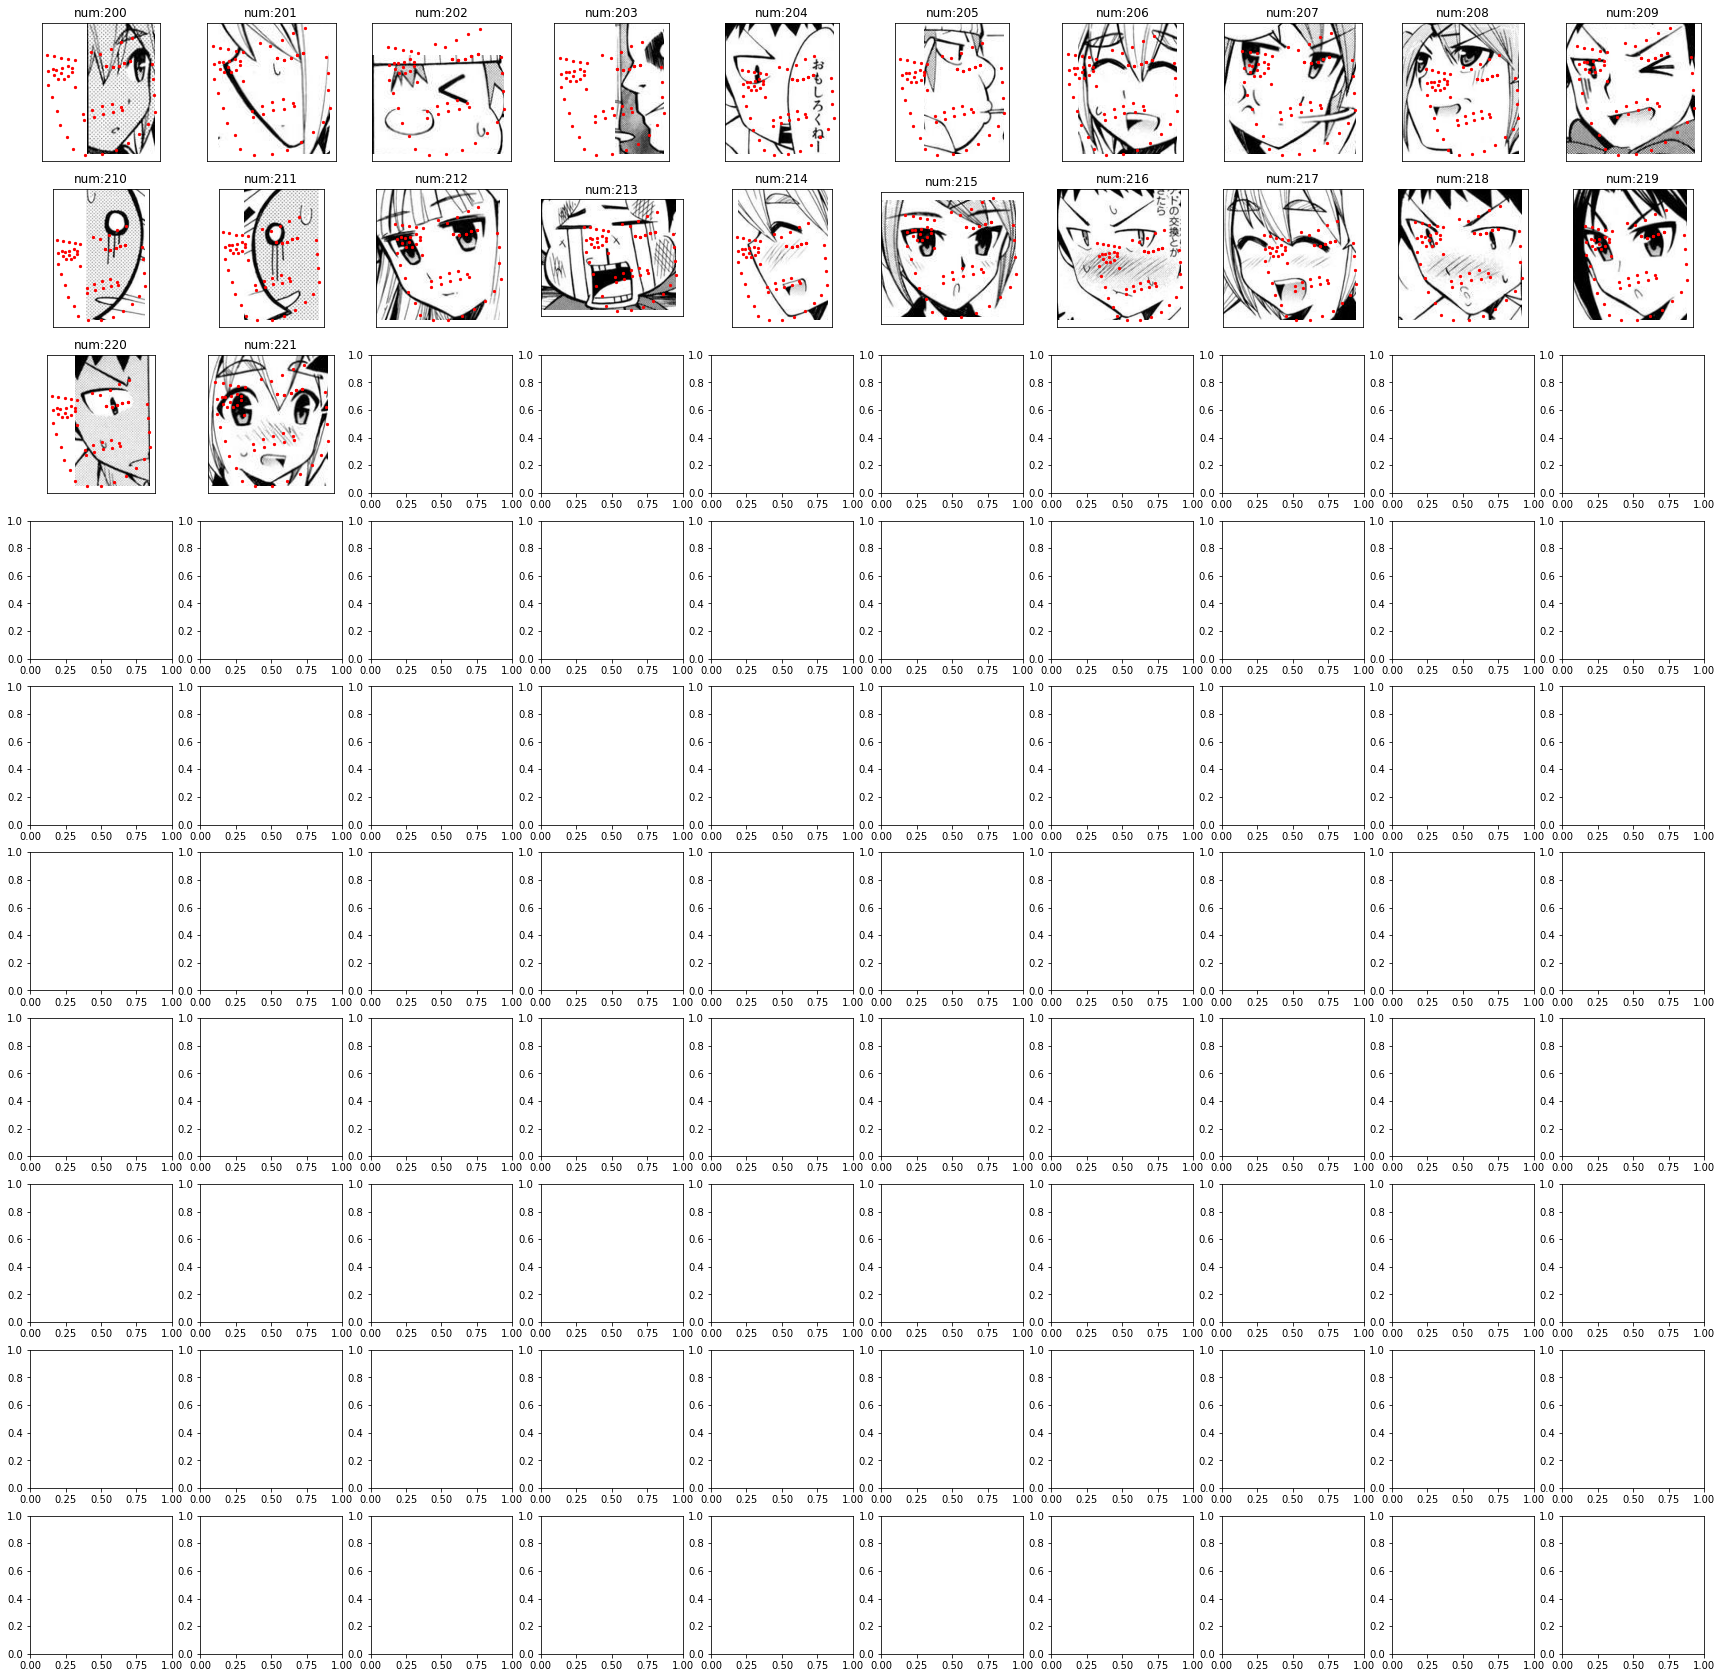

KeyboardInterrupt: ignored

In [ ]:
from numpy.core.fromnumeric import nonzero
import json


os.makedirs('./drive/MyDrive/Temp/img_landmark_dataset', exist_ok=True)
save_path = './drive/MyDrive/Temp/img_landmark_dataset'
root_file_list = os.listdir()
landmark_file_list = [i for i in root_file_list if 'user' in i]
landmark_file_list = sorted(landmark_file_list)
landmark_title_list = []
for i in landmark_file_list:
  temp = i[6:].split('_')
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  temp = '_'.join(temp)
  landmark_title_list.append(temp)

for landmark_idx, landmark_file in enumerate(landmark_file_list):
  print(f'랜드마크 번호 : {landmark_idx}')
  temp = landmark_file[6:].split('_')
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  temp.remove(temp[-1])
  title = '_'.join(temp)


  cropped_image_list = []
  with open(landmark_file,'r') as f:
    json_data = json.load(f)
  x = []
  y = []
  for part in list(json_data['Face'].keys()):
    try:
      [x.append(i) for i in np.array(json_data['Face'][part]['Landmarks'])[:,0]]
      [y.append(i) for i in np.array(json_data['Face'][part]['Landmarks'])[:,1]]
    except:
      continue
  
  title_image_path = f'/content/Manga109_released_2021_12_30/images/{title}'
  title_xml_path = f'/content/Manga109_released_2021_12_30/annotations.v2018.05.31/{title}.xml'
  tree = ET.parse(title_xml_path)
  root = tree.getroot()
  page_list = sorted(os.listdir(title_image_path))
  for page in page_list:
    image = cv2.imread(os.path.join(title_image_path, page))
    page_index = int(page.split('.')[0])
    for face_idx in range(len(root[1][page_index].findall('face'))):
      xmin = int(root[1][page_index].findall('face')[face_idx].attrib['xmin'])
      ymin = int(root[1][page_index].findall('face')[face_idx].attrib['ymin'])
      xmax = int(root[1][page_index].findall('face')[face_idx].attrib['xmax'])
      ymax = int(root[1][page_index].findall('face')[face_idx].attrib['ymax'])
      cropped_image = image[ymin:ymax,xmin:xmax]
      cropped_image_list.append(cropped_image)
  
  selected_cropped_image_list = []
  for image in cropped_image_list:
    x_ = [i-(max(x)-image.shape[1]) for i in x]
    y_ = [i-(max(y)-image.shape[0]) for i in y]
    if min(x_) >= 0 or min(y_) >= 0:
      if image.shape[1]/3 > min(x_) and image.shape[0]/3 > min(y_):
        selected_cropped_image_list.append(image)
          
  rows = 10
  cols = 10

  for show_page in range(len(selected_cropped_image_list)//(rows*cols)+1):
    print(f'page : {show_page}/{len(selected_cropped_image_list)//(rows*cols)}')
    f, ax = plt.subplots(rows,cols, figsize=(30,30))
  
    for image_idx, image_num in tqdm(enumerate(range(show_page*rows*cols,show_page*rows*cols+rows*cols))):
      try:
        x_ = [i-(max(x)-selected_cropped_image_list[image_num].shape[1]) for i in x]
        y_ = [i-(max(y)-selected_cropped_image_list[image_num].shape[0]) for i in y]
        ax[image_idx//rows][image_idx%cols].imshow(selected_cropped_image_list[image_num])
        ax[image_idx//rows][image_idx%cols].set_title(f'num:{image_num}')
        ax[image_idx//rows][image_idx%cols].scatter(x_,y_,s=5,color='red')
        ax[image_idx//rows][image_idx%cols].get_xaxis().set_visible(False)
        ax[image_idx//rows][image_idx%cols].get_yaxis().set_visible(False)
        
      except IndexError as e:
        break
    plt.show()
  
  while True:
    flag = None
    save_img_num = int(input('image num : '))
    x_ = [i-(max(x)-selected_cropped_image_list[save_img_num].shape[1]) for i in x]
    y_ = [i-(max(y)-selected_cropped_image_list[save_img_num].shape[0]) for i in y]
    plt.imshow(selected_cropped_image_list[save_img_num])
    plt.scatter(x_,y_,s=5,c='red')
    plt.show()
    while True:
      x_move = int(input('x 이동량:'))
      y_move = int(input('y 이동량:'))
      x__ = [i+x_move for i in x_]
      y__ = [i+y_move for i in y_]
      plt.imshow(selected_cropped_image_list[save_img_num])
      plt.scatter(x__,y__,s=5,c='red')
      plt.show()
      next = int(input('더 수정하고 싶으면 : 1 이미지를 다시 선택하려면 2 끝내고 싶으면 0을 이건못찾겠다 싶으면 -1을 입력하세요.\n'))
      
      if next==2:
        break
      elif next==-1:
        flag=True
        break
      elif next==0:
        np.save(f'{save_path}/img_{landmark_file}',np.array(selected_cropped_image_list[save_img_num]))
        np.save(f'{save_path}/landmark_{landmark_file}',np.stack([np.array(x__),np.array(y__)], axis=1))
        flag=True
        break
    if flag==True:
      break